# Phần 1. Tổng quan tập dữ liệu

1. Nhập các thư viện cần thiết

In [3796]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

2. Nhập tập dữ liệu

In [3797]:
df = pd.read_csv('heart.csv')

3. Tìm hiểu dữ liệu

3.1 In ra 5 dòng đầu của tập dữ liệu

In [3798]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,male,typical angina,145,233,True,hypertrophy,150,no,2.30,downsloping,0,fixed defect,more chance of heart attack
1,37,male,non-anginal pain,130,250,False,normal,187,no,3.50,downsloping,0,normal,more chance of heart attack
2,41,female,atypical angina,130,204,False,hypertrophy,172,no,1.40,upsloping,0,normal,more chance of heart attack
3,56,male,atypical angina,120,236,False,normal,178,no,0.80,upsloping,0,normal,more chance of heart attack
4,57,female,asymptomatic,120,354,False,normal,163,yes,0.60,upsloping,0,normal,more chance of heart attack


3.2 Thông tin tập dữ liệu

In [3799]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    bool   
 6   restecg   303 non-null    object 
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    object 
 11  caa       303 non-null    int64  
 12  thall     301 non-null    object 
 13  output    303 non-null    object 
dtypes: bool(1), float64(1), int64(5), object(7)
memory usage: 31.2+ KB


3.3 Kiểm tra số lượng giá trị duy nhất trong mỗi cột

In [3800]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
age,41
sex,2
cp,4
trtbps,49
chol,152
fbs,2
restecg,3
thalachh,91
exng,2
oldpeak,40


3.4 Tách các cột theo phân loại và liên tục

⭐ Chia các cột dữ liệu thành các biến phân loại và biến liên tục

In [3801]:
cat_cols = ['sex','cp','fbs','restecg','exng', 'slp', 'caa','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", con_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
The continuous cols are :  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
The target variable is :   ['output']


⭐ Biểu đồ các biến phân loại trong tập dữ liệu

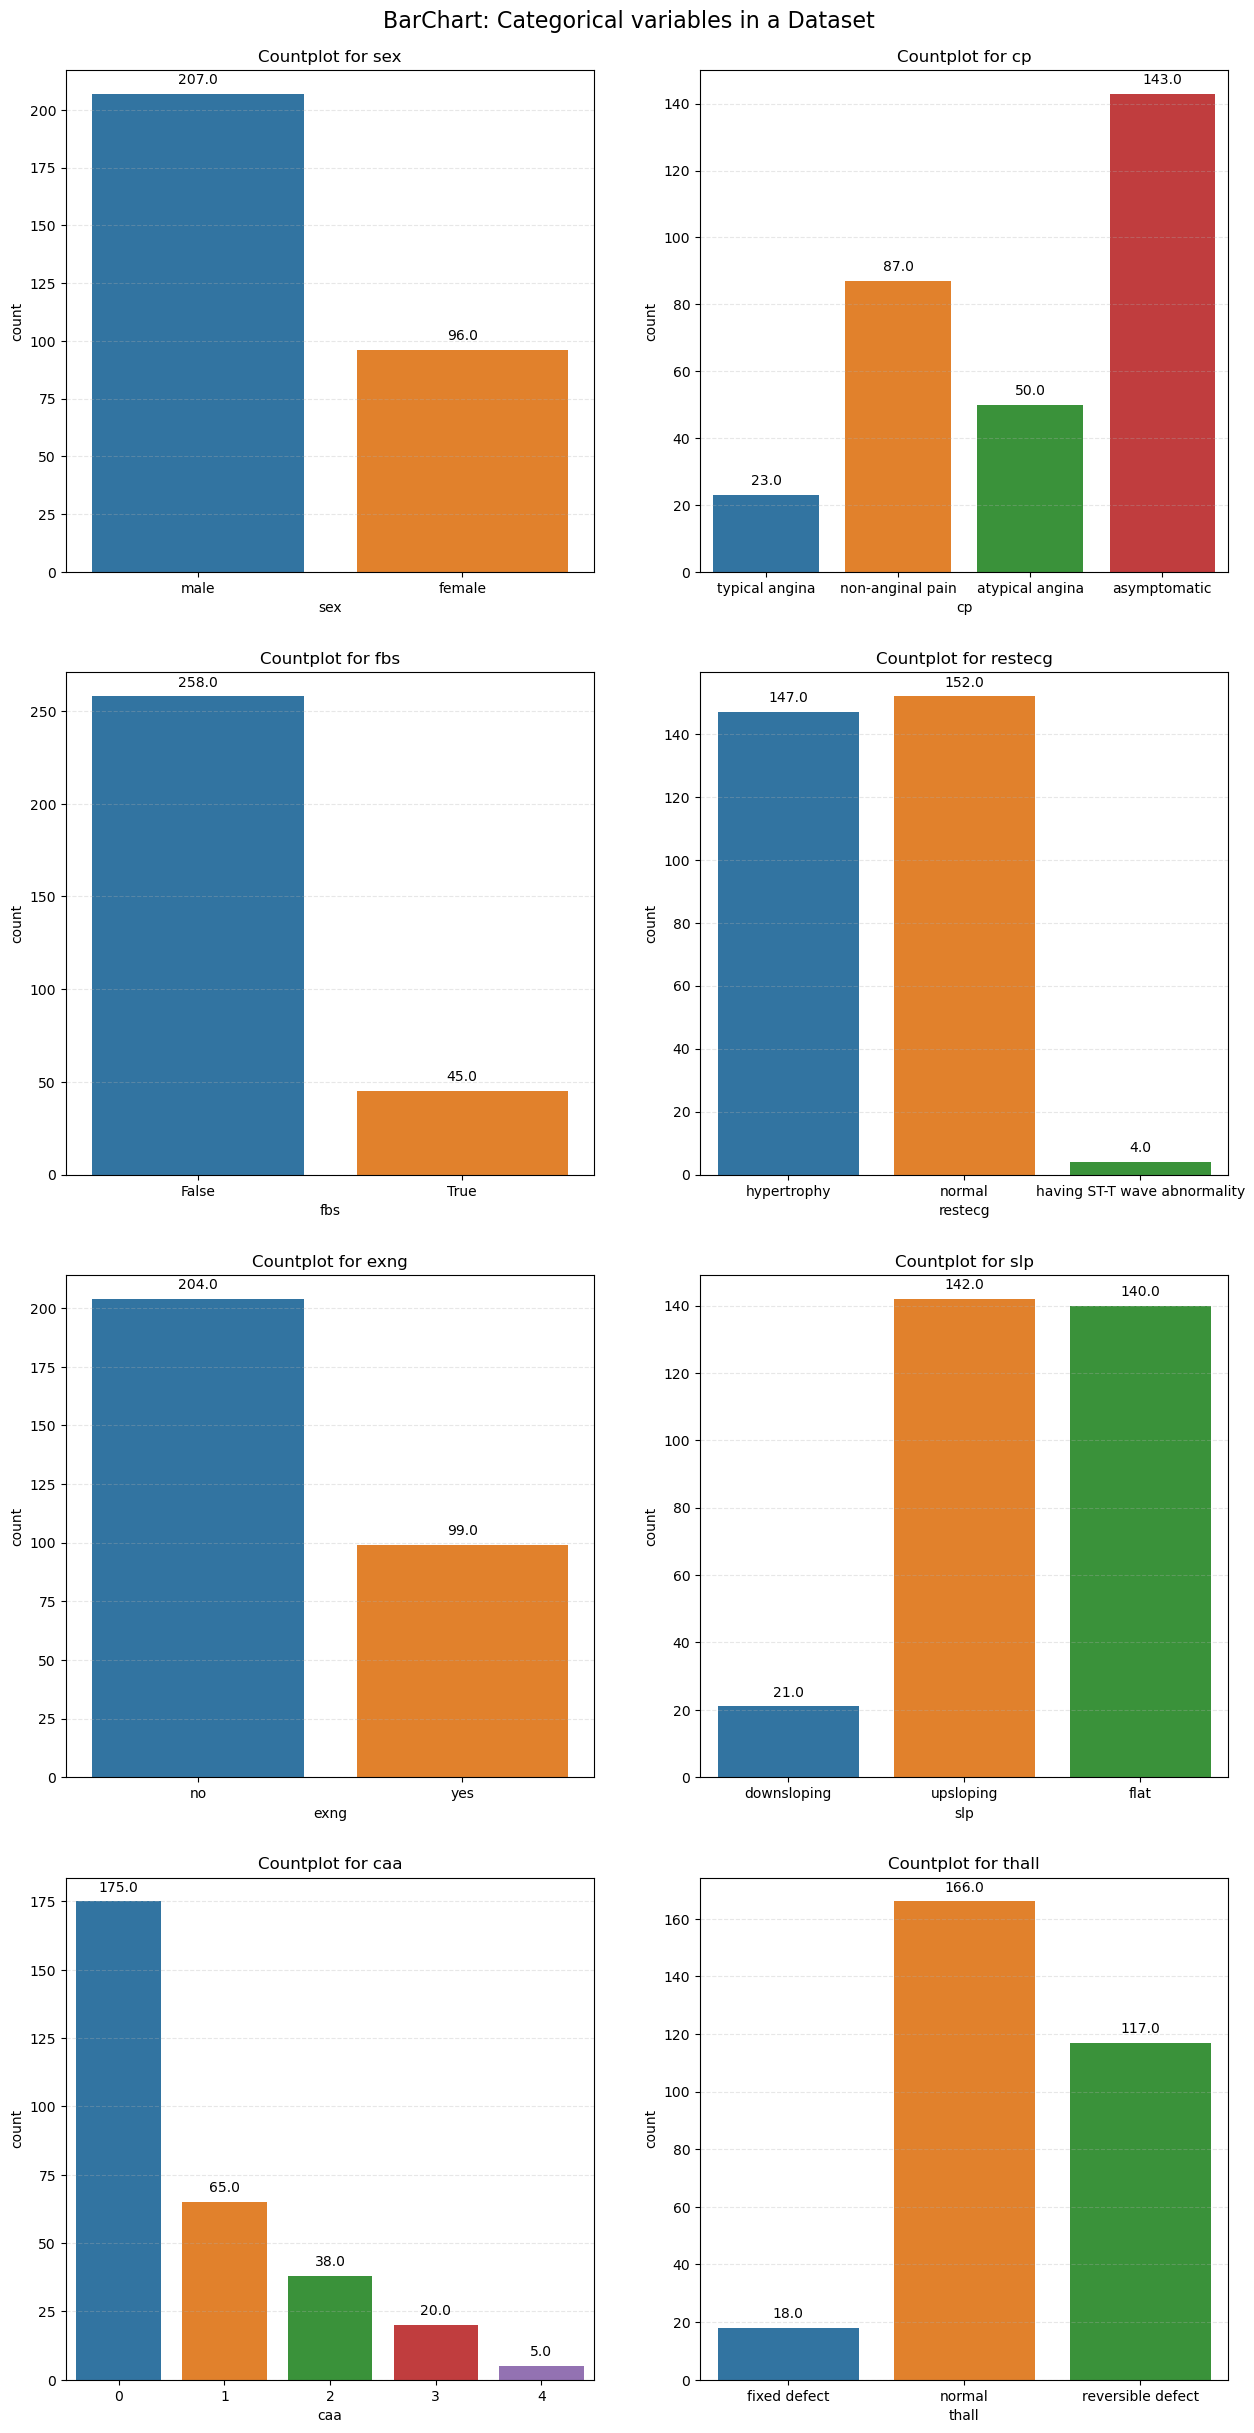

In [3802]:
# Tạo subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30))

# Duyệt qua các cột và vẽ countplot


for i, ax in zip(df[cat_cols].columns, axes.flatten()):
    sns.countplot(x=i, data=df[cat_cols], ax=ax)
    ax.set_title(f'Countplot for {i}')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    # Thêm lưới ngang
    for row in axes:
        for ax in row:
            ax.yaxis.grid(True, linestyle='--', alpha=0.3)

plt.suptitle("BarChart: Categorical variables in a Dataset", y=0.9, fontsize=16)  # Thêm tiêu đề chung
plt.show()

⭐ Biểu đồ các biến liên tục trong tập dữ liệu

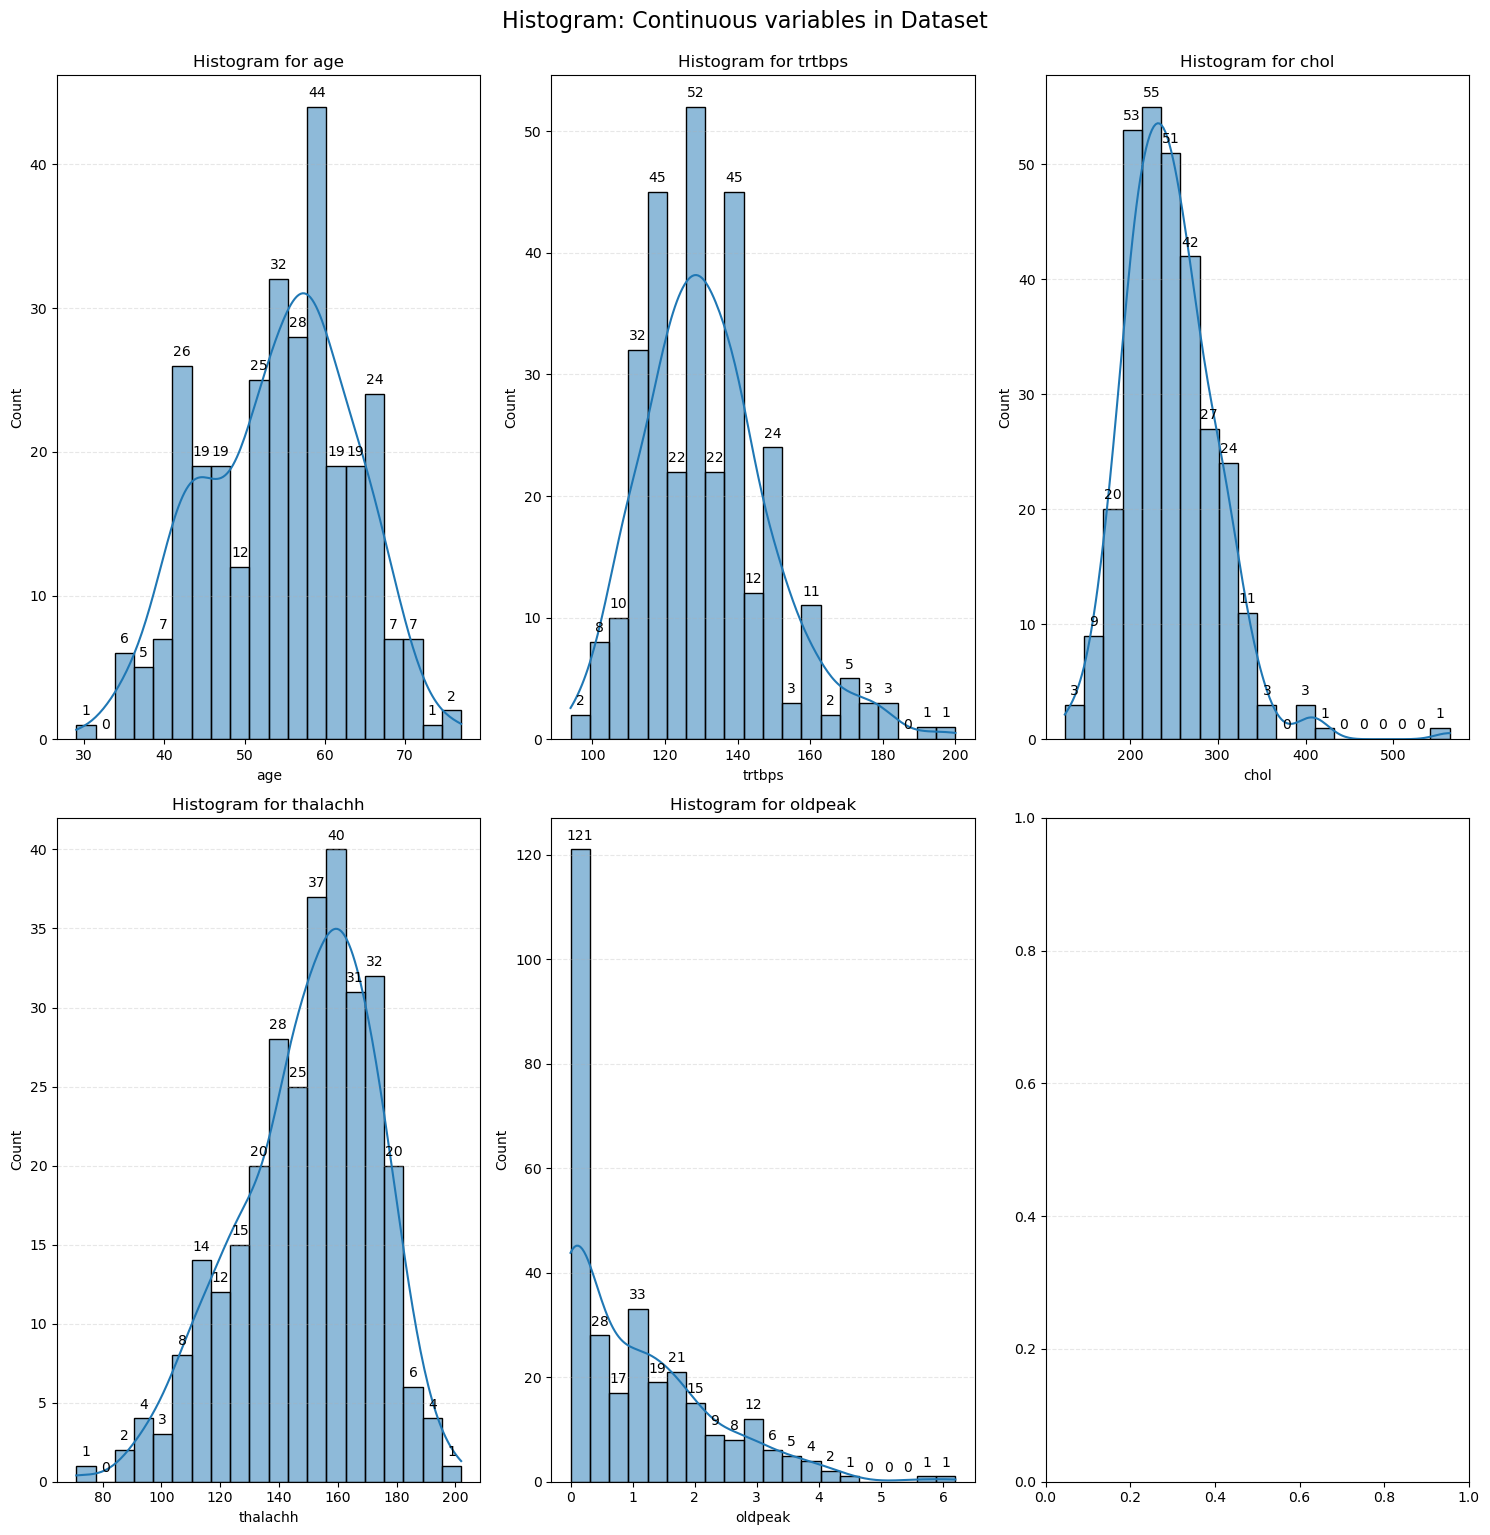

In [3803]:
# Tạo subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# Duyệt qua các cột và vẽ histogram
for col, ax in zip(con_cols, axes.flatten()):
    sns.histplot(df[col], bins=20, kde=True, ax=ax)
    ax.set_title(f'Histogram for {col}')
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    # Thêm lưới ngang
    for row in axes:
        for ax in row:
            ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# Tự chỉnh layout
plt.tight_layout()
plt.suptitle("Histogram: Continuous variables in Dataset", y=1.02, fontsize=16)  # Thêm tiêu đề chung
plt.show()

⭐ Biểu đồ kiểm tra giá trị ngoại lệ trong tập dữ liệu

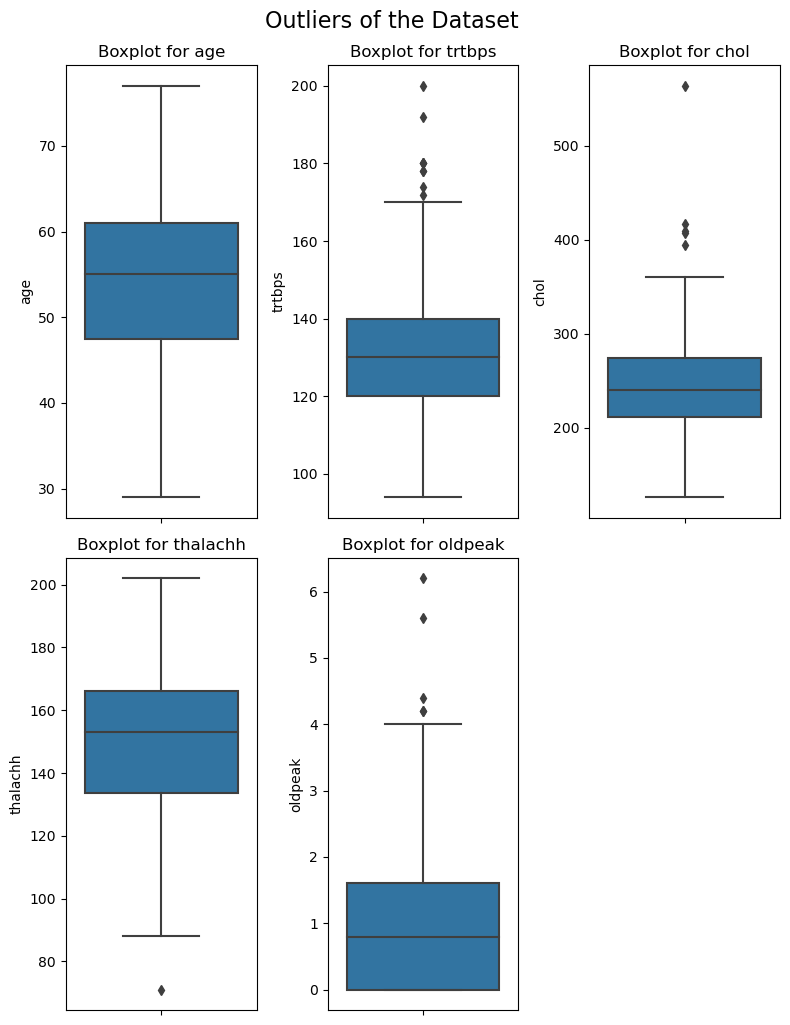

In [3804]:
plt.figure(figsize=(8, 10))

for i, column in enumerate(df[con_cols], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot for {column}')

plt.tight_layout()
plt.suptitle("Outliers of the Dataset ", y=1.02, fontsize=16)  # Thêm tiêu đề chung
plt.show()

3.5 Kiểm tra giá trị NaN

In [3805]:
# Kiểm tra giá trị NaN
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       2
output      0
dtype: int64

# Phần 2: Tiền xử lý dữ liệu

2.1 Kiểm tra và xử lý những giá trị trùng lặp

In [3806]:
# Kiểm tra các giá trị trùng lặp
df.duplicated().sum()

1

In [3807]:
# In ra cột chứa giá trị trùng lặp
df[df.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,male,non-anginal pain,138,175,False,normal,173,no,0.00,upsloping,4,normal,more chance of heart attack


In [3808]:
# Loại bỏ các dòng chứa giá trị trùng lặp
df = df.drop_duplicates()

In [3809]:
# Kiểm tra lại
df.duplicated().sum()

0

2.2 Xử lý giá trị NaN

In [3810]:
# Loại bỏ giá trị NaN
df = df.dropna()

In [3811]:
# Kiểm tra lại
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

2.3 Chuyển đổi dữ liệu

In [3812]:
df['sex'].replace({'male': 1, 'female': 0}, inplace=True)
df['cp'].replace({'asymptomatic': 0, 'atypical angina': 1, 'non-anginal pain': 2, 'typical angina': 3}, inplace=True)
df['restecg'].replace({'hypertrophy': 0, 'normal': 1, 'having ST-T wave abnormality': 2}, inplace=True)
df['fbs'].replace({True: 1, False: 0}, inplace=True)
df['exng'].replace({'yes': 1, 'no': 0}, inplace=True)
df['slp'].replace({'downsloping': 0, 'flat': 1, 'upsloping': 2}, inplace=True)
df['thall'].replace({'fixed defect': 1, 'normal': 2, 'reversible defect': 3}, inplace=True)
df['output'].replace({'less chance of heart attack': 0, 'more chance of heart attack': 1}, inplace=True)

In [3813]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1


2.4 Xử lý giá trị ngoại lệ

⭐ Hàm xử lý giá trị ngoại lệ

In [3814]:
def iqr(df, var):
    q1 = np.quantile(df[var], 0.25)
    q3 = np.quantile(df[var], 0.75)
    diff = q3 - q1
    lower_v = q1 - (1.5 * diff)
    upper_v = q3 + (1.5 * diff)
    return df[(df[var] < lower_v) | (df[var] > upper_v)]

2.4.1 Xử lý giá trị ngoại lệ cột thalachh

In [3815]:
# Giá trị trung bình
iqr(df, 'thalachh')['thalachh']

272    71
Name: thalachh, dtype: int64

In [3816]:
# Tìm giá trị bé nhất của cột
df[df['thalachh'] > 71].thalachh.min()

88

In [3817]:
# Thay thế giá trị trung bình vào giá trị ngoại lệ
df.at[272, 'thalachh'] = 88

2.4.2 Xử lý giá trị ngoại lệ cột trtbps

In [3818]:
# In ra các giá trị ngoại lệ của cột
iqr(df,'trtbps')['trtbps']

8      172
101    178
110    180
203    180
223    200
241    174
248    192
260    178
266    180
Name: trtbps, dtype: int64

In [3819]:
# In ra giá trị ngoại lệ nhỏ nhất của cột
iqr(df, 'trtbps')['trtbps'].min()

172

In [3820]:
# Tìm giá trị lớn nhất của cột (<172)
df[df['trtbps'] < 172].trtbps.max()

170

In [3821]:
# Tính phần trăm winsorize cho giá trị 170 trong cột "trtbps"
winsorize_percentile_trtbps = (stats.percentileofscore(df['trtbps'], 170)) / 100

# In ra phần trăm winsorize
print(winsorize_percentile_trtbps)
trtbps_winsorize = winsorize(df.trtbps, (0, (1 - winsorize_percentile_trtbps)))

# Lưu giá trị ngoại lệ đã được xử lý vào cột
df['trtbps'] = trtbps_winsorize

0.965


2.4.3 Xử lý giá trị ngoại lệ cột chol

In [3822]:
# In ra giá trị ngoại lệ nhỏ nhất của cột
iqr(df, 'chol')['chol'].min()

394

In [3823]:
# Tìm giá trị lớn nhất của cột (<394)
df[df['chol'] < 394].chol.max()

360

In [3824]:
# Tính phần trăm winsorize cho giá trị 360 trong cột "chol"
winsorize_percentile_chol = (stats.percentileofscore(df['chol'], 360)) / 100

# In ra phần trăm winsorize
print(winsorize_percentile_chol)
chol_winsorize = winsorize(df.chol, (0, (1 - winsorize_percentile_chol)))

# Lưu giá trị ngoại lệ đã được xử lý vào cột
df['chol'] = chol_winsorize

0.9833333333333333


2.4.4 Xử lý giá trị ngoại lệ cột oldpeak

In [3825]:
iqr(df, 'oldpeak')['oldpeak']

101   4.20
204   6.20
221   5.60
250   4.20
291   4.40
Name: oldpeak, dtype: float64

In [3826]:
# In ra giá trị ngoại lệ nhỏ nhất của cột
iqr(df, 'oldpeak')['oldpeak'].min()

4.2

In [3827]:
# Tìm giá trị lớn nhất của cột (<4.2)
df[df['oldpeak'] < 4.2].oldpeak.max()

4.0

In [3828]:
# Tính phần trăm winsorize cho giá trị 4 trong cột "oldpeak"
winsorize_percentile_oldpeak = (stats.percentileofscore(df['oldpeak'], 4)) / 100

# In ra phần trăm winsorize
print(winsorize_percentile_oldpeak)
oldpeak_winsorize = winsorize(df.oldpeak, (0, (1 - winsorize_percentile_oldpeak)))

# Lưu giá trị ngoại lệ đã được xử lý vào cột
df['oldpeak'] = oldpeak_winsorize

0.98


2.4.5 Kết quả sau khi xử lý giá trị ngoại lệ

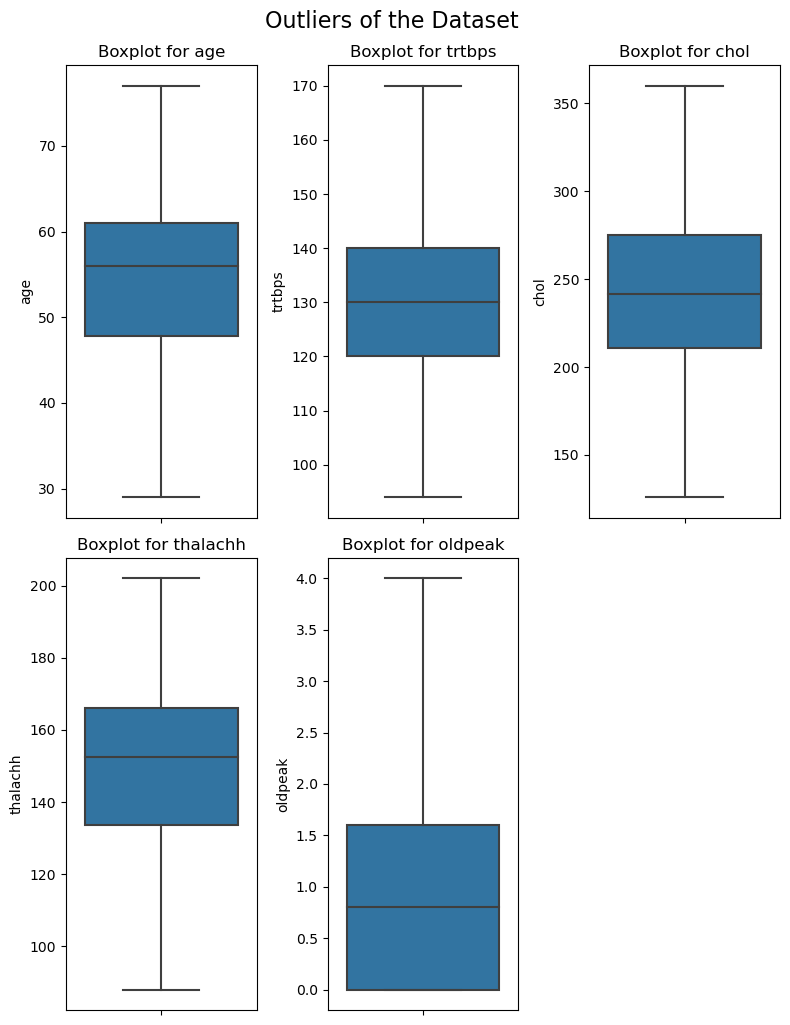

In [3829]:
plt.figure(figsize=(8, 10))

for i, column in enumerate(df[con_cols], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot for {column}')

plt.tight_layout()
plt.suptitle("Outliers of the Dataset ", y=1.02, fontsize=16)  # Thêm tiêu đề chung
plt.show()

# Phần 3: Mối tương quan của tập dữ liệu

3.1 

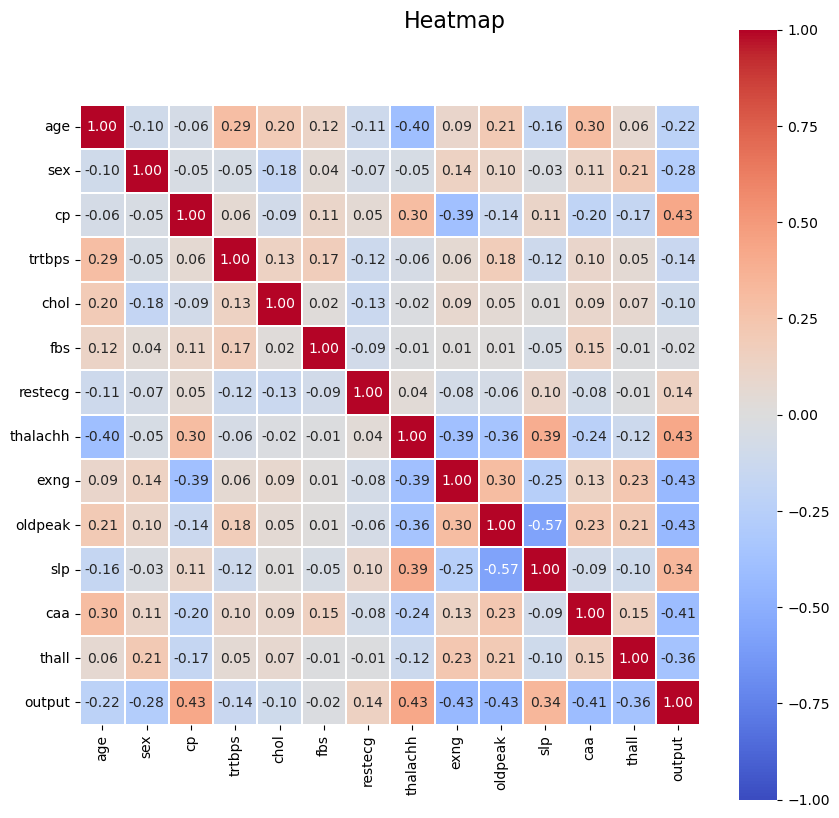

In [3830]:
corr = df.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", linewidths=.1, square=True, annot=True ,fmt=".2f")
plt.yticks(rotation=0)
plt.suptitle("Heatmap", y=0.9, fontsize=16)  # Thêm tiêu đề chung
plt.show()

# Phần 4. Chuẩn bị cho mô hình

In [3831]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1


  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 39.56it/s]

[LightGBM] [Info] Number of positive: 131, number of negative: 111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541322 -> initscore=0.165667
[LightGBM] [Info] Start training from score 0.165667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g